# Anomaly, changepoint, and segment detection with sktime and skchange

In [1]:
import datetime
import pathlib

import pandas as pd

## Overview of the Detection Module ("annotation")

<img src="img/annotation_tree.png" width="800">

**Outlier Detection**

1. Removing unrealistic data points.
1. Finding points or areas of interest.

**Change Point Detection**

1. Detecting detecting signifant changes in how your data is generated.

**Segmentation**

1. Finding sequences of anomalous points.
2. Finding common patterns or motifs in your dataset.

## Types of Outliers

1. Point outliers: Individual data point that are unusual compared to the whole timeseries (global) or neighbouring points (local).
1. Subsequence outliers: Sequence of inidividual points that are unusual when compared to others.
1. Finding anomalous timeseries.

## Detecting Point Outliers

A data point is a point outlier if it is extremely high or extremely low compared to the rest of the timeseries. We will train a model to detect point outliers on the Yahoo dataset.

The Yahoo timeseries contains synthetic labelled anomalies. In reality, outlier detection is usually an unsupervised learning task so the labels are not usually provided.

In [2]:
data_root = pathlib.Path("../sktime/datasets/data/")
df = pd.read_csv(data_root / "yahoo/yahoo.csv")
df.head()

,data,label
0,-46.394356,0
1,311.346234,0
2,543.279051,0
3,603.441983,0
4,652.807243,0


Plot the timeseries.

In [3]:
from sktime.detection.plotting.utils import plot_time_series_with_anomalies

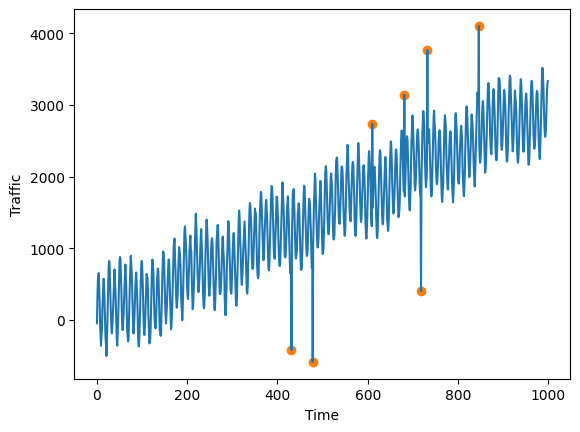

In [4]:
mask = df["label"] == 1.0
fig, _ = plot_time_series_with_anomalies(
    df.iloc[:, 0],
    X=df.loc[mask].index,
    y=df.loc[mask, "data"],
    X_label="Time",
    Y_label="Traffic",
)
fig.savefig("outlier_example.png")

Sktime provides several agorithms for anomaly detection. STRAY is one such algorithm.

In [5]:
from sktime.detection.stray import STRAY

model = STRAY()
model.fit(df["data"])
y_hat = model.transform(df["data"])  # True if anomalous, false otherwise
y_hat

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: data, Length: 1000, dtype: bool

Use `sum` to find the number of anomalies that have been detected.

In [6]:
y_hat.sum()

np.int64(3)

Plot the predicted anomalies.

In [7]:
from sktime.detection.plotting.utils import plot_time_series_with_predicted_anomalies

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Actual Anomalies'}>,
        <Axes: title={'center': 'Predicted Anomalies'}>], dtype=object))

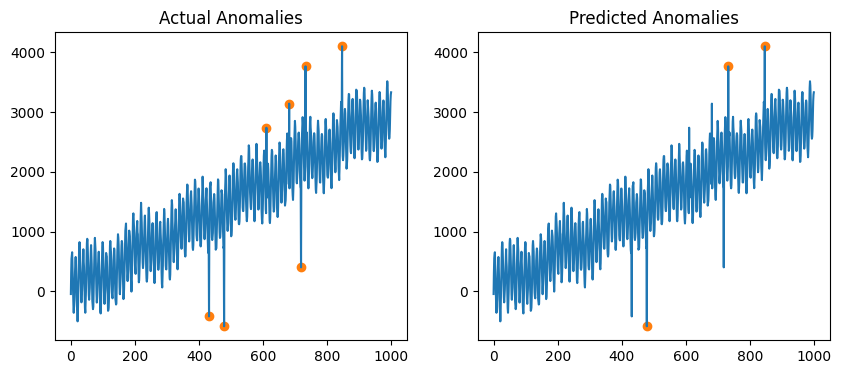

In [8]:
plot_time_series_with_predicted_anomalies(df, y_hat=y_hat)

STRAY is a modified version of the KNN algorithm. It cannot handle the trend in the timeseries so only the maximum and minimum values are flagged as anomalous.

Sktime provides methods for removing trend that can be used with STRAY.

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Actual Anomalies'}>,
        <Axes: title={'center': 'Actual Anomalies'}>], dtype=object))

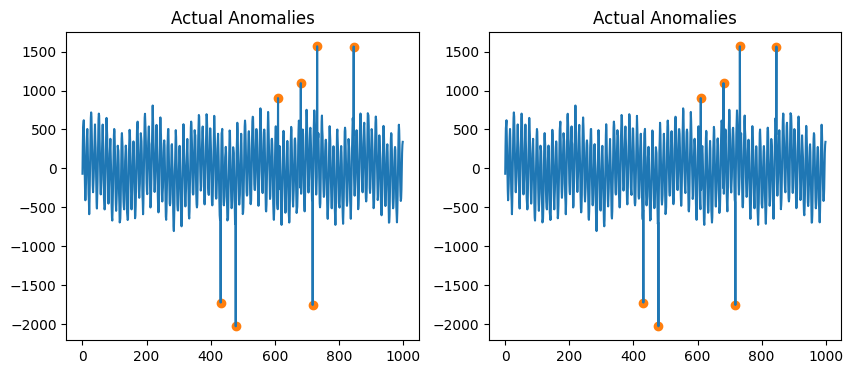

In [9]:
from sktime.detection.plotting.utils import plot_time_series_with_detrender
from sktime.transformations.series.detrend import Detrender

X_detrended = Detrender().fit_transform(df["data"])

model = STRAY()
model.fit(X_detrended)
y_hat = model.transform(X_detrended)

plot_time_series_with_detrender(df=df, detrended=X_detrended, y_hat=y_hat)

There is an even easier way to do this using the `*` operator.

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Actual Anomalies'}>,
        <Axes: title={'center': 'Actual Anomalies'}>], dtype=object))

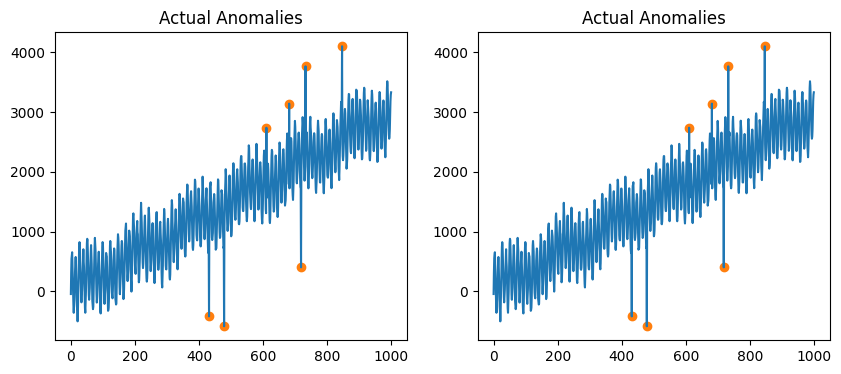

In [12]:
pipeline = Detrender() * STRAY()
pipeline.fit(df["data"])
y_hat = pipeline.transform(df["data"])

plot_time_series_with_detrender(
    df,
    y_hat,
)

## Detecting Subsequence Outliers

Subsequence outliers are groups of consecutive points whose behaviour is unusual. The `mitdb.csv` dataset is an ECG dataset and has an example of a subsequence outlier.

In [13]:
path = pathlib.Path(data_root / "mitdb/mitdb.csv")
df = pd.read_csv(path)
df.head()

,data,label
0,-0.195,0
1,-0.210,0
2,-0.210,0
3,-0.225,0
4,-0.220,0


Plot the timeseries.

(<Figure size 1000x400 with 1 Axes>, <Axes: >)

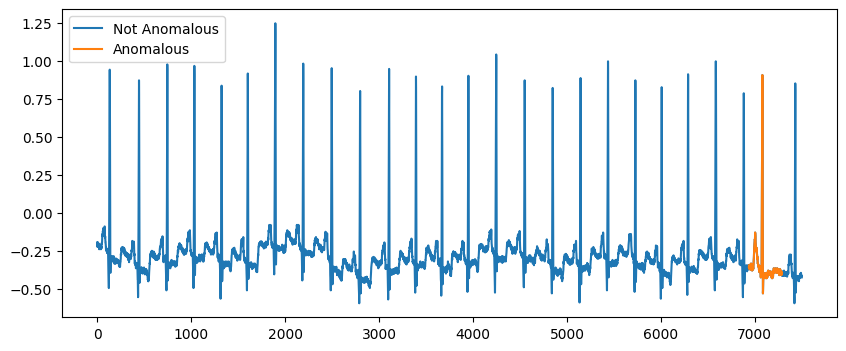

In [14]:
from sktime.detection.plotting.utils import plot_time_series_with_subsequent_outliers

plot_time_series_with_subsequent_outliers(df)

We can use Capa from Skchange to predict the anomalous subsequence. https://github.com/NorskRegnesentral/skchange.

Skchange is a package that is 2nd party supported by Sktime.

In [15]:
from skchange.anomaly_detectors import MVCAPA

model = MVCAPA(max_segment_length=350)
model.fit(df["data"])
anomaly_intervals = model.predict(df["data"])
anomaly_intervals

,ilocs,labels,icolumns
0,"[138, 440)",1,[0]
1,"[449, 741)",2,[0]
2,"[751, 1029)",3,[0]
3,"[1039, 1389)",4,[0]
4,"[1389, 1739)",5,[0]
5,"[2502, 2794)",6,[0]
6,"[2803, 3101)",7,[0]
7,"[3111, 3461)",8,[0]
8,"[3461, 3811)",9,[0]
9,"[3811, 4161)",10,[0]


In [16]:
print("left: ", anomaly_intervals.ilocs[18].left)
print("right: ", anomaly_intervals.ilocs[18].right)

left:  7084
right:  7426


Capa returns the anomalous subsequences as a series of intervals.

Plot the anomalous subsequence.

(<Figure size 1000x400 with 1 Axes>, <Axes: >)

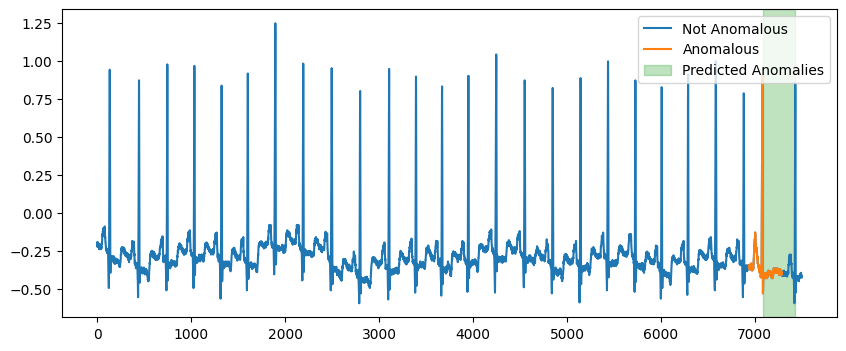

In [17]:
plot_time_series_with_subsequent_outliers(df, anomaly_intervals.ilocs[18:])

## Change Point Detection

Change point detection is used to find points in a timeseries where the underlying mechanism generating the data changes. 

The *seatbelt* dataset shows a change in the number of people who were killed or seariously injured on the road when wearing a seatbelt was made mandatory.

In [18]:
df = pd.read_csv(data_root / "seatbelts/seatbelts.csv", index_col=0, parse_dates=True)
df.head()

,KSI,label
1969-01-01,1687,0
1969-02-01,1508,0
1969-03-01,1507,0
1969-04-01,1385,0
1969-05-01,1632,0


Plot the seatbelt dataset.

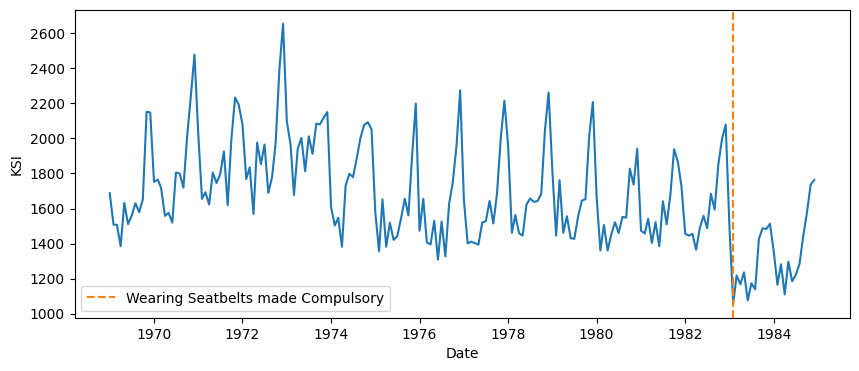

In [19]:
from sktime.detection.plotting.utils import plot_time_series_with_change_point_detection

actual_cp = datetime.datetime(1983, 2, 1)

fig, _ = plot_time_series_with_change_point_detection(
    df,
    actual_cp,
)
fig.savefig("seatbelt_example.png")

* It was made compulsory to wear a seatbelt in the UK on January 31st 1983.
* It was made mandatory to install seatbelts in all new cars in 1968.

Use binary segmentation to find change points where there is a drop in 1000 KSI.

In [20]:
from sktime.detection.bs import BinarySegmentation

model = BinarySegmentation(threshold=1000)
predicted_change_points = model.fit_predict(df["KSI"])
print(predicted_change_points)

   ilocs
0     71
1    168


For change point detectors, `predict` returns a series containing the indexes of the change points.

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Date', ylabel='KSI'>)

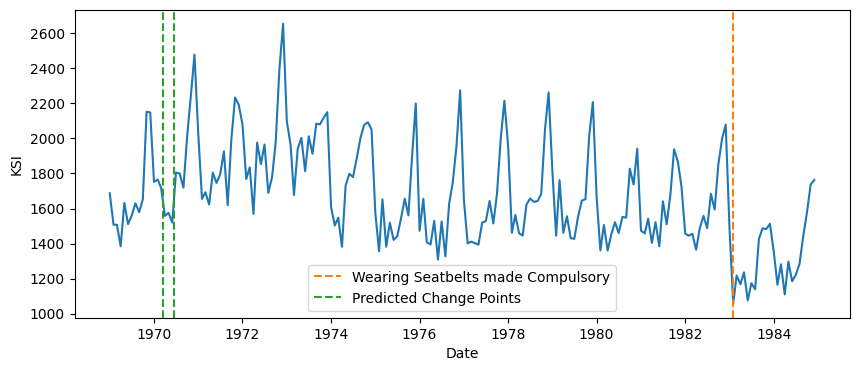

In [21]:
plot_time_series_with_change_point_detection(df, actual_cp, predicted_change_points)

The actual change point was identified almost exactly.

## Further Reading

* A Review on Outlier/Anomaly Detection in Time Series Data https://arxiv.org/pdf/2002.04236
* A review of change point detection algorithms https://arxiv.org/abs/2003.06222
* A discussion on the limitations of metrics for timeseries anomaly detection https://arxiv.org/pdf/2009.13807.

## Data Sources

* https://github.com/TheDatumOrg/TSB-UAD
* https://github.com/alan-turing-institute/TCPD

### Credits: notebook - anomaly, changepoint detection

notebook creation: alex-jg3
(notebook adapted from alex-jg3 notebook at ODSC 2024)

detection module design: fkiraly, miraep8, alex-jg3, lovkush-a, aiwalter, duydl, katiebuc, tveten

`skchange`: tveten, Norsk Regnesentral